In [183]:
# A noter que j'ai utilisé PYTHON 3 pour ce devoir
#V1

# Importation des librairies
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

On impose les graphiques *inline*, avec des dimensions standard.

In [184]:
%matplotlib inline
sns.set_context('notebook')
sns.set_style('darkgrid')
sns.set_palette('colorblind')

### 1) Écrire mathématiquement le modèle linéaire correspondant.

Si l'on considère p variables explicatives d'une valeur y, le modèle correspondant s'écrit :





$y_i = {\theta}_0^{*} + \sum_{j=1}^{p} {\theta}_j^{*}x_{ij} + {\epsilon}_i$    
avec : ${\epsilon}_i = {\cal{N}}(0,{\sigma}^2)~~~~~~~~~~ \forall i = 1,...,n$

Les bruits étant supposés i.i.d, gaussiens, un estimateur naturel des ${\theta}_j^{*}$ s'obtient par la méthode des moindres carrés.

### 2+3) Récupérer le jeu de données

In [185]:
airq = sm.datasets.get_rdataset('airquality')
airq_data = sm.datasets.get_rdataset('airquality').data
print (airq.__doc__)
airq_data.head()

+--------------+-------------------+
| airquality   | R Documentation   |
+--------------+-------------------+

New York Air Quality Measurements
---------------------------------

Description
~~~~~~~~~~~

Daily air quality measurements in New York, May to September 1973.

Usage
~~~~~

::

    airquality

Format
~~~~~~

A data frame with 154 observations on 6 variables.

+------------+---------------+-----------+---------------------------+
| ``[,1]``   | ``Ozone``     | numeric   | Ozone (ppb)               |
+------------+---------------+-----------+---------------------------+
| ``[,2]``   | ``Solar.R``   | numeric   | Solar R (lang)            |
+------------+---------------+-----------+---------------------------+
| ``[,3]``   | ``Wind``      | numeric   | Wind (mph)                |
+------------+---------------+-----------+---------------------------+
| ``[,4]``   | ``Temp``      | numeric   | Temperature (degrees F)   |
+------------+---------------+-----------+----------------

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41,190,7.4,67,5,1
1,36,118,8.0,72,5,2
2,12,149,12.6,74,5,3
3,18,313,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


In [186]:
#Suppression des lignes avec des paramètres vides
print("Nombre d'observations avant suppression des lignes avec des vides :"+str(len(airq_data)))
airq_data = airq_data.dropna()
print("Nombre d'observations après suppression des lignes avec des vides :"+str(len(airq_data)))

Nombre d'observations avant suppression des lignes avec des vides :153
Nombre d'observations après suppression des lignes avec des vides :111


### 4) Ajuster le modèle par la méthode des moindres carrés après avoir centré-réduits les variables

In [187]:
# définition des variables explicatives et de la variable à estimer
X = airq_data[['Solar.R', 'Wind', 'Temp', 'Month', 'Day']]
Y = airq_data['Ozone']

# Centrage et Réduction des variables explicatives
X_mean=np.mean(X)
X_ecartType = np.std(X)
Xrescale = (X - X_mean)/X_ecartType

# ajout de la colonne des 1 (Y non normalisés)
Xrescale=sm.add_constant(Xrescale)

# Calcul des paramètres de l'estimateur des moindres carrés avec statsmodels
thetaChapeau = sm.OLS(Y,Xrescale).fit().params

# Affichage des coefficients et de l'ordonnée à l'origine (const)
print ("Les coefficients sont affichés ci-dessous en fâce des variables explicatives concernées (const pour l'ordonnée à l'origine)")
print (thetaChapeau)

Les coefficients sont affichés ci-dessous en fâce des variables explicatives concernées (const pour l'ordonnée à l'origine)
const      42.099099
Solar.R     4.561931
Wind      -11.752771
Temp       17.985220
Month      -4.458953
Day         2.373939
dtype: float64


##### Remarque : Il apparait une influence relativemment importante de la température (comme facteur augmentant la concentration d'ozone) et du vent (comme facteur diminuant la concentration en ozone). Les intervalles de confiance doivent cependant être calculés avant toute conclusion.

### 5) Estimateur sans biais de la variance du bruit

L'estimateur  sans biais de la variance du bruit s'écrit : ${\widehat\sigma}^2 = \frac{1}{n-rg(X)}{\left \| y - X{\widehat\theta} \right \|}^2_2$

In [188]:
#calcul du résultat ci-dessus avec nos données
rang = sm.OLS(Y,Xrescale).fit().df_model # rang de la matrice de régression
n=len(airq_data) # nombre d'observations sans NA
Y_moinsXTheta=Y-np.dot(Xrescale,thetaChapeau)
sigmaCarre = (1/(n-rang))*np.dot(Y_moinsXTheta.T,Y_moinsXTheta)
print("La valeur de l'estimateur sans biais de la variance : ",round(sigmaCarre,2)) # Valeur numérique de l'estimateur sans biais de la variance

La valeur de l'estimateur sans biais de la variance :  430.97


### 6) Intervalle de confiance de niveau 0.01 pour la quantité ${\widehat\theta}$

In [189]:
# IC pourt les moindres carrés
import scipy.stats 
ordreQuantile = 1-(0.01/2) # quantile de la loi de Student 
quantileOrdre0995 = scipy.stats.t.ppf(ordreQuantile,n-rang-1)


In [190]:
invXtXrescale=np.linalg.inv(np.dot(Xrescale.T,Xrescale))
invXtXrescale_jj=np.diag(invXtXrescale)
marge=quantileOrdre0995*np.sqrt(sigmaCarre)*np.sqrt(invXtXrescale_jj)
Intervalle = pd.DataFrame()
Intervalle['Valeur estimée']=thetaChapeau
Intervalle['Marge Inf à 99%'] = thetaChapeau-marge
Intervalle['Marge Sup à 99%'] = thetaChapeau+marge
Intervalle

,Valeur estimée,Marge Inf à 99%,Marge Sup à 99%
const,42.099099,36.929726,47.268472
Solar.R,4.561931,-0.986633,10.110494
Wind,-11.752771,-17.712853,-5.792689
Temp,17.985220,11.200770,24.769670
Month,-4.458953,-10.255276,1.337370
Day,2.373939,-2.824057,7.571935


### 7) Interprétation de l'intervalle de confiance

0 étant dans les IC pour le mois et le jour, ces valeurs sont potentiellement non explicatives du niveau d'Ozone

### 8) Prédiction

In [191]:
nouvelObs=np.array([197,10,70,3,1])
nouvelObs_rescale = (nouvelObs-X_mean)/X_ecartType
nouvelObs_rescale = np.append(1,nouvelObs_rescale) # ajout du terme 1 pour piloter 'const'
Prevision = np.dot(nouvelObs_rescale,thetaChapeau)
print("La prévision du modèle en concentration en ozone pour la nouvelle observation est : ",round(Prevision,2))

La prévision du modèle en concentration en ozone pour la nouvelle observation est :  36.46


# EXERCICE 2

### 1) Calculer les Estimateurs des coefficients obtenus

In [192]:
import sklearn.utils
ListeDeThetaestimé_sample=pd.DataFrame()
Comparaison_bootstrap_MCOpur=pd.DataFrame()

for i in range(0,10000):
    airq_data_resample = sklearn.utils.resample(airq_data,replace='True') # calcul d'un sample (avec remise)
    Ysample = airq_data_resample['Ozone']
    Xsample = airq_data_resample[['Solar.R', 'Wind', 'Temp', 'Month', 'Day']]
    # Centrage et Réduction des variables explicatives
    Xsample_mean=np.mean(Xsample)
    Xsample_ecartType = np.std(Xsample)
    Xsample_rescale = (Xsample - Xsample_mean)/Xsample_ecartType
    Xsample_rescale=sm.add_constant(Xsample_rescale)
    # MCO sur le sample
    theta_estimé_sample = sm.OLS(Ysample,Xsample_rescale).fit().params
    ListeDeThetaestimé_sample['sample : '+ str(i)]=theta_estimé_sample
# Changement des lignes en colonnes    
ListeDeThetaestimé_sample=ListeDeThetaestimé_sample.T

# Affichage des coefficients estimés pour les 5 premiers samples   
ListeDeThetaestimé_sample.head()

,const,Solar.R,Wind,Temp,Month,Day
sample : 0,40.495495,4.447101,-12.882116,15.131995,-5.870531,6.788488
sample : 1,36.981982,4.563347,-6.615780,16.839345,-4.036081,3.249168
sample : 2,36.441441,3.036709,-8.789300,17.306197,-4.753305,2.184860
sample : 3,41.027027,5.515239,-10.681413,18.700654,-3.792789,3.693356
sample : 4,41.126126,3.466659,-9.629827,17.608299,-2.892819,2.326090


Le tableau ci-dessus indique les 5 premiers samples du bootstrap

In [193]:
# Comparaison des valeurs de l'exercice 1 et du bootstrap 
Comparaison_bootstrap_MCOpur["MCO pur"]=thetaChapeau
Comparaison_bootstrap_MCOpur["bootstr+moy"]=ListeDeThetaestimé_sample.mean()
Comparaison_bootstrap_MCOpur["bootstr+med"]=ListeDeThetaestimé_sample.median()
Moyenne_des_coefficients=Comparaison_bootstrap_MCOpur.mean(axis=1)
Ecart_type_des_coefficients=Comparaison_bootstrap_MCOpur.std(axis=1)

Comparaison_bootstrap_MCOpur["moy 3 methodes"]=Moyenne_des_coefficients
Comparaison_bootstrap_MCOpur["std 3 methodes"]=Ecart_type_des_coefficients

Comparaison_bootstrap_MCOpur 

,MCO pur,bootstr+moy,bootstr+med,moy 3 methodes,std 3 methodes
const,42.099099,42.132126,42.054054,42.095093,0.039190
Solar.R,4.561931,4.555767,4.532310,4.550003,0.015629
Wind,-11.752771,-11.769421,-11.598757,-11.706983,0.094095
Temp,17.985220,17.920518,17.927396,17.944378,0.035537
Month,-4.458953,-4.449060,-4.451094,-4.453035,0.005225
Day,2.373939,2.378119,2.357009,2.369689,0.011178


Commentaire : La moyenne ou la médiane des échantillons du bootstrap permettent d'approcher les coefficients avec une précision interessante au regard de l'écart-type à la moyenne des 3 méthodes

### 2/Intervalle de confiance de niveau 99% avec les quantiles empiriques de bootstrap

In [194]:
#Calcul de l'IC
ListeDeThetaestimé_sample.quantile([.005,.995])

,const,Solar.R,Wind,Temp,Month,Day
0.005,34.189144,-0.134182,-19.990714,11.932757,-9.480974,-3.040282
0.995,50.414820,9.343756,-5.016349,23.784856,0.678868,7.719075


### 3) impact du nombre d'échantillon du bootstrap (example de la variable 'Wind')

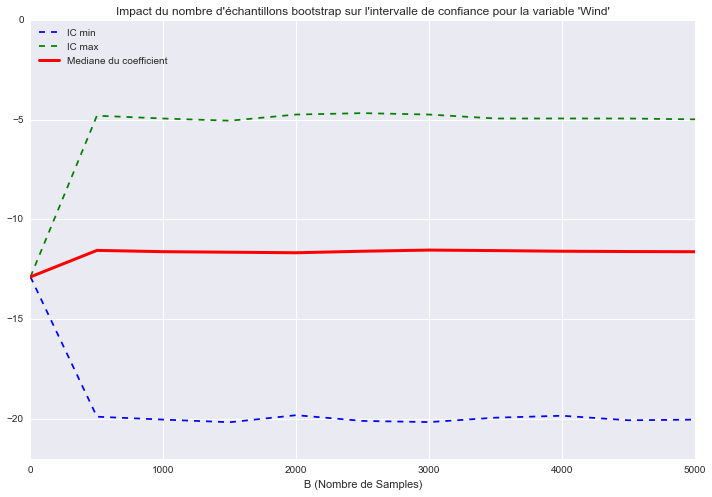

In [195]:
tableau_de_IC=pd.DataFrame(columns=["B",'0.005','0.995','MED'])
for i in np.linspace(1,5001,11):
    tableau_de_IC.loc[int(i),"B"]=int(i)
    tableau_de_IC.loc[int(i),'0.005']=ListeDeThetaestimé_sample[0:int(i)].quantile([.005]).iloc[0,2]
    tableau_de_IC.loc[int(i),'0.995']=ListeDeThetaestimé_sample[0:int(i)].quantile([.995]).iloc[0,2]
    tableau_de_IC.loc[int(i),'MED']=ListeDeThetaestimé_sample.iloc[0:int(i),2].median()

fig = plt.figure(figsize=(10, 7))
plt.xlim(xmin=0, xmax=5000)
plt.ylim(ymin=-22, ymax=0)
xlabels = 'B (Nombre de Samples)'
ylabels = ' '

plt.plot(tableau_de_IC.iloc[:,0],tableau_de_IC.iloc[:,1],'b--',label="IC min")
plt.plot(tableau_de_IC.iloc[:,0],tableau_de_IC.iloc[:,2],'g--',label="IC max")
plt.plot(tableau_de_IC.iloc[:,0],tableau_de_IC.iloc[:,3],linewidth=3,color='red',label="Mediane du coefficient")

plt.legend(numpoints=1, loc=2)
plt.xlabel(xlabels), plt.ylabel(ylabels)
plt.title("Impact du nombre d'échantillons bootstrap sur l'intervalle de confiance pour la variable 'Wind'")
plt.tight_layout()
plt.show()

#### commentaire : convergence rapide (à partir de 500 échantillons). Il n'est pas utile de prendre plus

## 4) régression de Ozone sur wind

/Users/florian/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


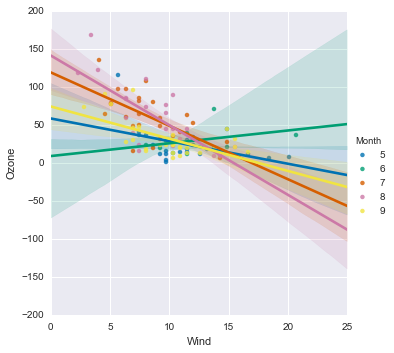

In [196]:
sns.lmplot('Wind','Ozone',hue='Month',data=airq_data,size=5)

Commentaire : Alors que sur tous les mois (sauf juin) , la concentration en ozone diminue avec le vent, c'est l'inverse pour juin

# EXERCICE 3

### 1) fonction stepforward

In [197]:
def stpforward(Y,Xrescale,M,fit_intercept=True):
    
    # initialisation des variables
    r=Y
    S=[]
    Indice_debut_de_matrice = 0
    
    # cas où on veut récupérer theta0
    if fit_intercept == True: 
        Xrescale=sm.add_constant(Xrescale)
        S.append(0)
        Indice_debut_de_matrice=1
    
    # début de l'algorithme (boucle sur le nombre de paramètres à ajouter)
    for m in range(0,M):
        Fitting_max = 0 # initialisation de la variable "résultat du produit scalaire"       
        
        # calcul du max du produit scalaire |<Xj,r>| pour tout j
        for j in range(Indice_debut_de_matrice,Xrescale.shape[1]):
            Fitting_Xj_Y =  np.abs(np.dot(Xrescale[:,j].T,r))
            if (Fitting_Xj_Y >= Fitting_max and j not in S):
                Fitting_max = Fitting_Xj_Y
                indiceJ=j
        # Ajout du max trouvé au tableau S        
        S.append(indiceJ)
        
        #Calcul de la régression sur les anciennes colonnes X plus la dernière ajoutée
        Xs=Xrescale[:,S]
        thetaInt = sm.OLS(Y,Xs).fit().params
        r=Y-np.dot(Xs,thetaInt)
    
    #thetaS est sparse
    thetaS=thetaInt.as_matrix()
    
    # construction du vecteur theta non sparse
    theta=np.zeros(Xrescale.shape[1])
    indice_depart=0
    for j in S:
            theta[j]=thetaS[indice_depart]
            indice_depart +=1
    
    # retour de theta sparse et de la liste ordonnée des indices choisis
    return theta,S

### 2) Création de la classe MYOMP

In [198]:
from sklearn.linear_model.base import LinearModel, _pre_fit
from sklearn.base import RegressorMixin

class MYOMP(LinearModel, RegressorMixin):
    def __init__(self, n_nonzero_coefs=None, fit_intercept=True,normalize=True, precompute='auto'):
        self.n_nonzero_coefs = n_nonzero_coefs
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute
        
    def fit(self, X, y):
        X, y, X_mean, y_mean, X_std, Gram, Xy = _pre_fit(X, y, None, self.precompute, self.normalize, self.fit_intercept, copy=True)
        self.coef_ = np.zeros([X.shape[1], ])    
        #Appel de la fonction stpForward 
        self.coef_,self.S = stpforward(y,X,self.n_nonzero_coefs,False)
        self._set_intercept(X_mean, y_mean, X_std)
        return self

### 3) Application de MYOMP à AIRQUALITY pour M=3,4,5

In [199]:
for M in range(3,6):
    a=MYOMP(M)
    a.fit(X,Y)
    print("Les coordonnées de theta, pour M=",M,", sont :",a.coef_)
    print("la liste S des indices des variables utilisées (dans l'ordre de sélection) :",a.S,"\n")

Les coordonnées de theta, pour M= 3 , sont : [ 0.05982059 -3.33359131  1.65209291  0.          0.        ]
la liste S des indices des variables utilisées (dans l'ordre de sélection) : [2, 1, 0] 

Les coordonnées de theta, pour M= 4 , sont : [ 0.04959683 -3.3165094   1.87087379 -2.99162786  0.        ]
la liste S des indices des variables utilisées (dans l'ordre de sélection) : [2, 1, 0, 3] 

Les coordonnées de theta, pour M= 5 , sont : [ 0.05027432 -3.31844386  1.89578642 -3.03995664  0.27387752]
la liste S des indices des variables utilisées (dans l'ordre de sélection) : [2, 1, 0, 3, 4] 



### 4) Utilisation de  la fonction OrthogonalMatchingPursuit de sklearn

In [200]:
from sklearn.linear_model import OrthogonalMatchingPursuit

for  M in range(3,6):    
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=M, normalize = True)
    omp.fit(X, Y)
    print ("Les coordonnées de theta, pour M=",M,", sont :",omp.coef_)

Les coordonnées de theta, pour M= 3 , sont : [ 0.05982059 -3.33359131  1.65209291  0.          0.        ]
Les coordonnées de theta, pour M= 4 , sont : [ 0.04959683 -3.3165094   1.87087379 -2.99162786  0.        ]
Les coordonnées de theta, pour M= 5 , sont : [ 0.05027432 -3.31844386  1.89578642 -3.03995664  0.27387752]


Les sorties de l'algorithme codé précédamment et de la fonction OrthogonalMatchingPursuit de Scikit-Learn sont rigoureusement identiques

### 5) Utilisation de la validation croisée pour choisir le nombre de variables à garder

In [201]:
from sklearn.cross_validation import KFold
kf=KFold(n=X.shape[0],n_folds=X.shape[0],shuffle=True,random_state=2)

Normes_Residus_par_M = {} # dictionnaire qui contiendra les normes quadratiques des résidus moyens pour chaque M

for M in range(1,6):
    #greedy sur M varaibles
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=M, normalize = True)
    tableau_des_normes_residus=[]
    
    for train_index, test_index in kf:
        omp.fit(X.iloc[train_index,:],Y.iloc[train_index])
        # calcul de la norme quadratique du résidu
        residu_sample=Y.iloc[test_index]-np.dot(X.iloc[test_index,:],omp.coef_)
        norme_carré_residu_sample=np.dot(residu_sample.T,residu_sample)
        tableau_des_normes_residus.append(norme_carré_residu_sample)
    # Moyenne des normes quadratiques des résidus pour M fixé
    moyenne_norme_carre_residu_sample=sum(tableau_des_normes_residus)/len(tableau_des_normes_residus)
    Normes_Residus_par_M["M="+str(M)]= moyenne_norme_carre_residu_sample

print(Normes_Residus_par_M)

{'M=1': 22373.08731449072, 'M=3': 4578.1232778484746, 'M=4': 3787.658650926589, 'M=5': 4531.4304125375293, 'M=2': 4974.9358076631934}


#### La plus petite norme des résidus sur le test_set apparait pour M=4 qui est donc la valeur optimale à prendre